:::{markdown}
## 1. Data Loading and Initial Exploration

This section loads the processed dataset containing GPCR plasma membrane expression (PME) scores and a curated set of biologically relevant features. Only specific topological features are used for model training and analysis are extracted here.
:::

In [1]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)
import shap

# Set working directory
os.chdir('/home/goel107/GPCRs/GPCR_ML_2-NEW/')

# Load dataset
df_gpcr = pd.read_csv('HIGH_EXPRESSION_GPCR_TRANSCRIPT_PROTEIN_FEATURES.csv')

# Define the list of specific features to extract
selected_features = [
    'compound_name', 'GPCR_PME', 'relative_tmd_1', 'relative_tmd_2', 'relative_tmd_3', 'relative_tmd_4', 'relative_tmd_5', 'relative_tmd_6', 'relative_tmd_7',
    'relative_N_terminal_loop_length', 'relative_downstream_loop_length_1', 'relative_upstream_loop_length_1',
    'relative_downstream_loop_length_2', 'relative_upstream_loop_length_2', 'relative_downstream_loop_length_3',
    'relative_upstream_loop_length_3', 'relative_C_terminal_loop_length', 'Molecular_Weight', 'Isoelectric_Point', 'Aromaticity', 'instability_index', 'gravy',
    'adjusted_tmd_delta_G_1', 'adjusted_tmd_delta_G_2', 'adjusted_tmd_delta_G_3', 'adjusted_tmd_delta_G_4',
    'adjusted_tmd_delta_G_5', 'adjusted_tmd_delta_G_6', 'adjusted_tmd_delta_G_7'
]

# Create new dataframe with selected features
df_selected = df_gpcr[selected_features]

# Extract features for initial exploration
df_features_raw = df_selected.iloc[:, 2:]

# Check for NaNs
nan_summary = df_features_raw.isna().sum()
print("NaN summary per feature:")
print(nan_summary[nan_summary > 0])  # Only show features with NaNs

# Impute NaNs with median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df_features_raw = pd.DataFrame(imputer.fit_transform(df_features_raw), columns=df_features_raw.columns)

# Verify no NaNs left
print(f"NaNs after imputation: {df_features_raw.isna().sum().sum()}")

print(f"Dataset shape: {df_selected.shape}")
print(f"PME range: {df_selected['GPCR_PME'].min():.2f} - {df_selected['GPCR_PME'].max():.2f}")

NaN summary per feature:
Series([], dtype: int64)
NaNs after imputation: 0
Dataset shape: (452, 29)
PME range: 82.90 - 6534.16


/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


:::{markdown}
## 2. PME Distribution Analysis for Cutoff Selection

This section analyzes the distribution of GPCR plasma membrane expression (PME) values to guide the selection of a threshold for binary classification (high vs low PME). Various percentiles, descriptive statistics, and visual tools (histograms, KDE plots, CDF) are used to determine a biologically reasonable and data-driven cutoff — ultimately guiding supervised classification downstream.
:::

PME Distribution Statistics:
Mean: 2171.18
Median: 658.37
Standard Deviation: 2495.04
IQR: 4790.64

Potential Reference Points for Manual Cutoff Selection:

Percentiles:
  10th: 125.04
  25th: 153.17
  33rd: 197.74
  median: 658.37
  67th: 2644.28
  75th: 4943.81

Outlier Boundaries:
  lower_fence: -7032.80
  upper_fence: 12129.77

📊 Class Distribution Preview for Common Cutoffs:
25th percentile (153): 113 low (25.0%) vs 339 high (75.0%)
33rd percentile (198): 149 low (33.0%) vs 303 high (67.0%)
Median (658): 226 low (50.0%) vs 226 high (50.0%)
67th percentile (2644): 303 low (67.0%) vs 149 high (33.0%)
75th percentile (4944): 339 low (75.0%) vs 113 high (25.0%)

🎯 Manual PME Cutoff Selected: 2644

📊 Class Distribution with Manual Cutoff:
Low PME (< 2644): 303 samples – Class 0
High PME (≥ 2644): 149 samples – Class 1
Class imbalance ratio: 0.49:1


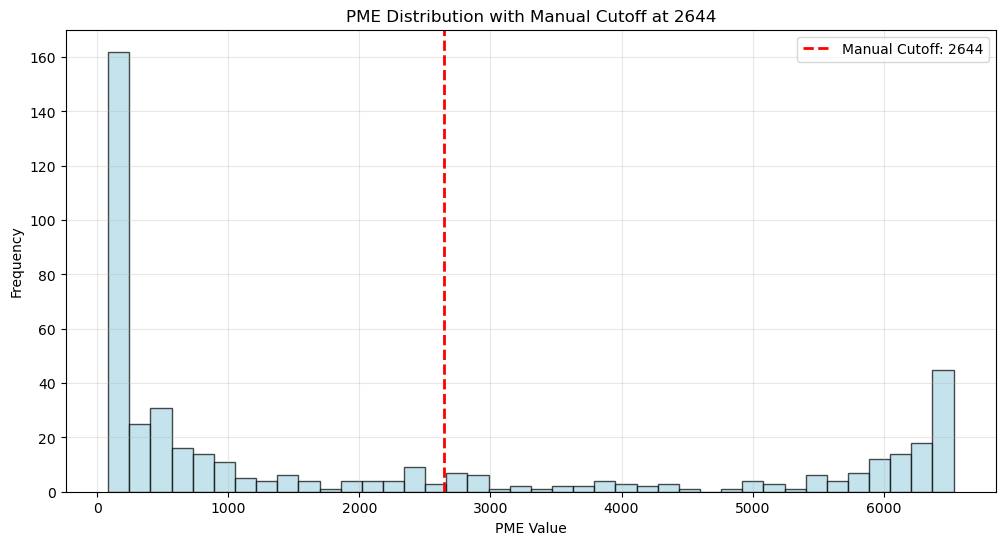

✅ Cutoff appears reasonable for binary classification.


In [2]:
# SCRIPT 2: PME Distribution Analysis and Manual Cutoff Application
pme = df_selected['GPCR_PME']

# Calculate comprehensive statistical summary
stats_summary = pme.describe(percentiles=[0.05, 0.10, 0.25, 0.33, 0.50, 0.67, 0.75, 0.90, 0.95])
iqr = stats_summary['75%'] - stats_summary['25%']

print("PME Distribution Statistics:")
print(f"Mean: {stats_summary['mean']:.2f}")
print(f"Median: {stats_summary['50%']:.2f}")
print(f"Standard Deviation: {stats_summary['std']:.2f}")
print(f"IQR: {iqr:.2f}")

# Potential threshold reference points
threshold_references = {
    'percentiles': {
        '10th': stats_summary['10%'],
        '25th': stats_summary['25%'],
        '33rd': stats_summary['33%'],
        'median': stats_summary['50%'],
        '67th': stats_summary['67%'],
        '75th': stats_summary['75%']
    },
    'outlier_boundaries': {
        'lower_fence': stats_summary['25%'] - 1.5*iqr,
        'upper_fence': stats_summary['75%'] + 1.5*iqr
    }
}

print("\nPotential Reference Points for Manual Cutoff Selection:")
for method, values in threshold_references.items():
    print(f"\n{method.replace('_', ' ').title()}:")
    for k, v in values.items():
        print(f"  {k}: {v:.2f}")

print(f"\n📊 Class Distribution Preview for Common Cutoffs:")
common_cutoffs = [stats_summary['25%'], stats_summary['33%'], stats_summary['50%'], stats_summary['67%'], stats_summary['75%']]
cutoff_names = ['25th percentile', '33rd percentile', 'Median', '67th percentile', '75th percentile']

for cutoff, name in zip(common_cutoffs, cutoff_names):
    low_count = np.sum(pme < cutoff)
    high_count = len(pme) - low_count
    low_pct = (low_count / len(pme)) * 100
    print(f"{name} ({cutoff:.0f}): {low_count} low ({low_pct:.1f}%) vs {high_count} high ({100-low_pct:.1f}%)")

# MANUAL PME CUTOFF SECTION 
# Replace this value with your chosen cutoff based on biological knowledge
MANUAL_PME_CUTOFF = 2644  # Example: Change this to your desired cutoff

print(f"\n🎯 Manual PME Cutoff Selected: {MANUAL_PME_CUTOFF}")

# Create binary labels using manual cutoff
y = (df_selected['GPCR_PME'] >= MANUAL_PME_CUTOFF).astype(int)

# Display class distribution
high_pme_count = np.sum(y)
low_pme_count = len(y) - high_pme_count
low_pme_pct = (low_pme_count / len(y)) * 100

print(f"\n📊 Class Distribution with Manual Cutoff:")
print(f"Low PME (< {MANUAL_PME_CUTOFF}): {low_pme_count} samples – Class 0")
print(f"High PME (≥ {MANUAL_PME_CUTOFF}): {high_pme_count} samples – Class 1")

# Calculate class imbalance ratio
imbalance_ratio = high_pme_count / max(low_pme_count, 1)  # Avoid division by zero
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")

# Visualize the cutoff on PME distribution
plt.figure(figsize=(12, 6))
plt.hist(df_selected['GPCR_PME'], bins=40, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(MANUAL_PME_CUTOFF, color='red', linestyle='--', linewidth=2, 
           label=f'Manual Cutoff: {MANUAL_PME_CUTOFF}')
plt.xlabel('PME Value')
plt.ylabel('Frequency')
plt.title(f'PME Distribution with Manual Cutoff at {MANUAL_PME_CUTOFF}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Validate cutoff reasonableness
if MANUAL_PME_CUTOFF > df_selected['GPCR_PME'].max():
    print("⚠️  WARNING: Cutoff exceeds maximum PME value in dataset!")
elif MANUAL_PME_CUTOFF < df_selected['GPCR_PME'].min():
    print("⚠️  WARNING: Cutoff is below minimum PME value in dataset!")
elif low_pme_pct < 5 or low_pme_pct > 95:
    print("⚠️  WARNING: Extreme class imbalance detected. Consider adjusting cutoff.")
else:
    print("✅ Cutoff appears reasonable for binary classification.")

✅ Data split completed:
Training set: 361 samples
Test set: 91 samples
Training class ratio: 33.0% high PME
✅ Feature scaling completed (no data leakage)
Scaled training shape: (361, 27)
Scaled test shape: (91, 27)
✅ Random Forest model trained

📊 Model Performance:
Balanced Accuracy: 0.676
Precision:         0.667
Recall:            0.467
F1-Score:          0.549
ROC-AUC:           0.767

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82        61
           1       0.67      0.47      0.55        30

    accuracy                           0.75        91
   macro avg       0.72      0.68      0.69        91
weighted avg       0.74      0.75      0.73        91


📊 Confusion Matrix:
TP: 14, FP: 7, TN: 54, FN: 16
True Positive Rate (Recall): 0.467
False Positive Rate: 0.115

🔍 Computing SHAP values...


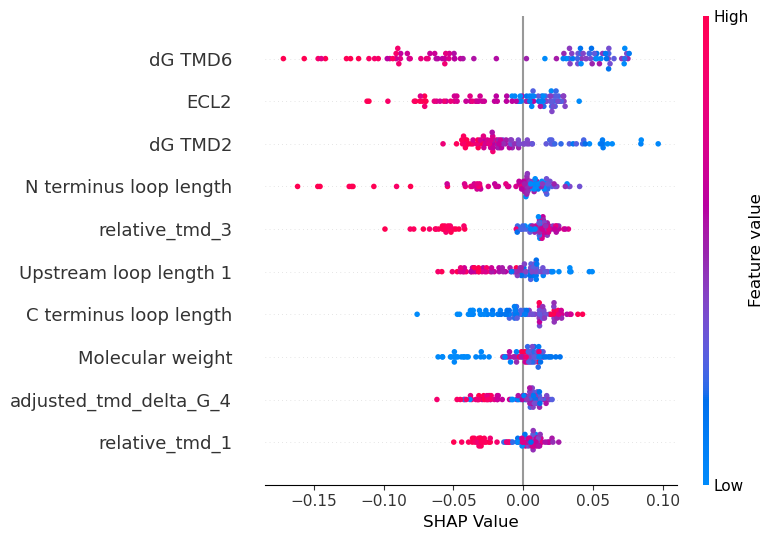


🌲 Random Forest Gini-based Feature Importances:
                          Feature  Gini Importance
                          dG TMD6         0.098877
                             ECL2         0.058035
                   relative_tmd_3         0.051214
                          dG TMD2         0.048221
                 Molecular weight         0.047441
           N terminus loop length         0.045177
           C terminus loop length         0.042567
           Upstream loop length 1         0.036848
           adjusted_tmd_delta_G_4         0.036057
                      Aromaticity         0.035077
           adjusted_tmd_delta_G_1         0.033748
                   relative_tmd_1         0.033335
                instability_index         0.032942
relative_downstream_loop_length_2         0.032026
           adjusted_tmd_delta_G_3         0.031771
                   relative_tmd_2         0.031695
                Isoelectric_Point         0.031588
           adjusted_tmd_delta_G_5

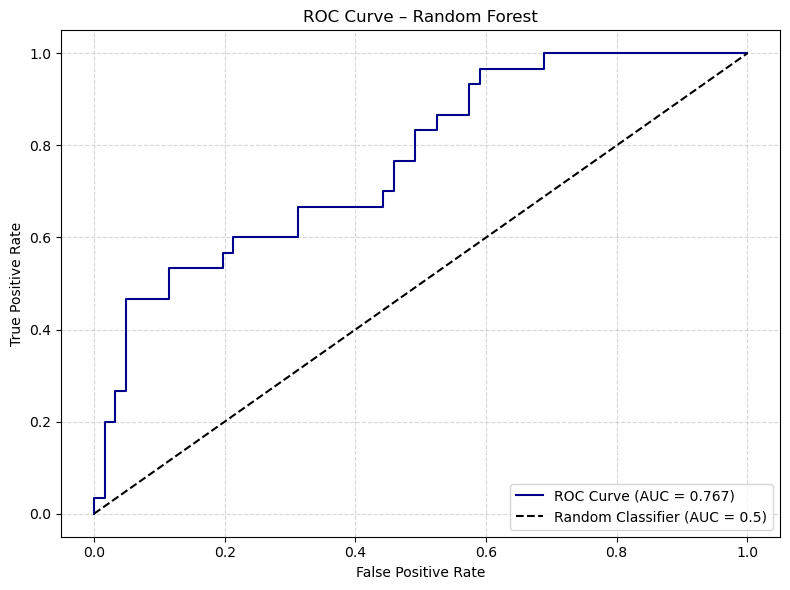

In [3]:
# Basic Random Forest (no hyperparameter tuning)
# Set global random seed for additional reproducibility
np.random.seed(42)

# Train-Test Split (preserve DataFrame structure for ColumnTransformer)
X_train, X_test, y_train, y_test = train_test_split(
    df_features_raw,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print(f"✅ Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class ratio: {np.mean(y_train)*100:.1f}% high PME")

# Feature Scaling (fit on training data only - prevents data leakage)
X_train_scaled = X_train.values
X_test_scaled  = X_test.values
print(f"✅ Feature scaling completed (no data leakage)")
print(f"Scaled training shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")

# Model Training
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
print(f"✅ Random Forest model trained")

# 4. Model Evaluation
y_pred  = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

bal_accuracy = balanced_accuracy_score(y_test, y_pred)
precision    = precision_score(y_test, y_pred)
recall       = recall_score(y_test, y_pred)
f1           = f1_score(y_test, y_pred)
roc_auc      = roc_auc_score(y_test, y_proba)

print(f"\n📊 Model Performance:")
print(f"Balanced Accuracy: {bal_accuracy:.3f}")
print(f"Precision:         {precision:.3f}")
print(f"Recall:            {recall:.3f}")
print(f"F1-Score:          {f1:.3f}")
print(f"ROC-AUC:           {roc_auc:.3f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Confusion Matrix:")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"True Positive Rate (Recall): {tp / (tp + fn):.3f}")
print(f"False Positive Rate: {fp / (fp + tn):.3f}")

# 🔍 SHAP Feature Importance Analysis
print(f"\n🔍 Computing SHAP values...")
np.random.seed(42)
explainer    = shap.TreeExplainer(rf_model)
shap_values  = explainer.shap_values(X_test_scaled)
if isinstance(shap_values, list):
    shap_class_values = shap_values[1]
elif shap_values.ndim == 3:
    shap_class_values = shap_values[:, :, 1]
else:
    shap_class_values = shap_values
    
# Map original feature names to publication labels
rename_map = {
    'sasa_total': 'sasa total',
    'sasa_crg': 'sasa crg',
    'sasa_aplr': 'sasa aplr',
    'isolated_beta_bridge': 'isolated beta bridge',
    'adjusted_tmd_delta_G_6': 'dG TMD6',
    'alpha_helix': 'Alpha Helix',
    'Molecular_Weight': 'Molecular weight',
    'relative_upstream_loop_length_2': 'ECL2',
    'relative_C_terminal_loop_length': 'C terminus loop length',
    'relative_N_terminal_loop_length': 'N terminus loop length',
    'relative_upstream_loop_length_3': 'Upstream loop length 3',
    'relative_upstream_loop_length_1': 'Upstream loop length 1',
    'relative_tmd_5': 'Length TMD5',
    'adjusted_tmd_delta_G_2': 'dG TMD2',
}    

# Prepare display names for SHAP plot - use actual feature names from df_features_raw
feature_names_list = list(df_features_raw.columns)
display_names = [rename_map.get(f, f) for f in feature_names_list]

# SHAP Summary Plot (top 10 features)
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_class_values,
    X_test_scaled,
    feature_names=display_names,
    plot_type='dot',
    max_display=10,
    show=False
)

plt.xlabel('SHAP Value', fontsize=12)
plt.tight_layout()

# Save as high-resolution PDF
plt.savefig('SHAP-highGFP-topology1.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# 🌲 Gini-based Feature Importance
print("\n🌲 Random Forest Gini-based Feature Importances:")
importances = rf_model.feature_importances_
feature_names = display_names  # From your renaming step

# Create and display a sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini Importance': importances
}).sort_values(by='Gini Importance', ascending=False)

print(importance_df.to_string(index=False))

# 🔍 Enhanced ROC Data Export for Origin Plotting
print(f"\n📈 Generating comprehensive ROC data for Origin plotting...")

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Create comprehensive ROC DataFrame for export
roc_df = pd.DataFrame({
    'False_Positive_Rate': fpr,
    'True_Positive_Rate': tpr,
    'Threshold': thresholds,
    'Specificity': 1 - fpr,  # 1 - FPR
    'Sensitivity': tpr,      # Same as TPR
    'Point_Index': range(len(fpr))
})

# Add additional calculated metrics
roc_df['Youden_J'] = roc_df['True_Positive_Rate'] + roc_df['Specificity'] - 1
roc_df['Distance_to_Perfect'] = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Display ROC data summary
print(f"✅ ROC Data Generated:")
print(f"  Total data points: {len(roc_df)}")
print(f"  AUC Score: {roc_auc:.6f}")
print(f"  FPR range: {fpr.min():.6f} to {fpr.max():.6f}")
print(f"  TPR range: {tpr.min():.6f} to {tpr.max():.6f}")
print(f"  Threshold range: {thresholds.min():.6f} to {thresholds.max():.6f}")

# Optional: Print all data in copy-pasteable format
print(f"\n📋 Complete ROC Data (Copy-Paste Ready for Origin):")
print("# GPCR PME ROC Curve Data")
print("# False_Positive_Rate\tTrue_Positive_Rate\tThreshold\tSpecificity\tSensitivity\tPoint_Index\tYouden_J\tDistance_to_Perfect")

for idx, row in roc_df.iterrows():
    print(f"{row['False_Positive_Rate']:.8f}\t{row['True_Positive_Rate']:.8f}\t{row['Threshold']:.8f}\t{row['Specificity']:.8f}\t{row['Sensitivity']:.8f}\t{row['Point_Index']}\t{row['Youden_J']:.8f}\t{row['Distance_to_Perfect']:.8f}")

# 🧪 Visual ROC Curve for Smoothness Check
plt.figure(figsize=(8, 6))
plt.plot(roc_df['False_Positive_Rate'], roc_df['True_Positive_Rate'], label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, precision_score, recall_score
import psutil 
import gc      
import time

process = psutil.Process()  

# Use local copy to avoid modifying original y_train ---
X_comparison = X_train_scaled
y_comparison = y_train.copy()
y_comparison = pd.Series(y_comparison).astype(int) # ensure 0/1 integers
print(f"🔍 Comparing models using {X_comparison.shape[0]} training samples...")

# --- Define classifiers ---
classifiers = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced', max_iter=1000)),
    ('k-NN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(class_weight='balanced', random_state=42)),
    ('SVM Linear', SVC(kernel='linear', class_weight='balanced', random_state=42)),
    ('SVM RBF', SVC(class_weight='balanced', random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Neural Network', MLPClassifier(max_iter=1000, random_state=42))
]
# --- Define scorers ---
scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'roc_auc': 'roc_auc'
}
# --- Run cross-validation ---
print(f"Memory before loop: {process.memory_info().rss / (1024 ** 2):.2f} MB")  # NEW: Memory before

results = []
for name, clf in classifiers:
    print(f" Evaluating {name}... (Start time: {time.strftime('%H:%M:%S')})")
    mem_before_model = process.memory_info().rss / (1024 ** 2)
    print(f"  Memory before {name}: {mem_before_model:.2f} MB")
    try:
        cv_results = cross_validate(
            clf, X_comparison, y_comparison,
            cv=5,
            scoring=scoring,
            n_jobs=1,
            return_train_score=False
        )
        metrics_dict = {'Classifier': name}
        for metric in scoring:
            key = f'test_{metric}'
            metrics_dict[metric.capitalize()] = np.mean(cv_results[key])
        results.append(metrics_dict)
    except Exception as e:
        print(f"❌ {name} failed: {e}")
    mem_after_model = process.memory_info().rss / (1024 ** 2)
    print(f"  Memory after {name}: {mem_after_model:.2f} MB (End time: {time.strftime('%H:%M:%S')})")
    gc.collect()  # Existing cleanup


print(f"Memory after loop: {process.memory_info().rss / (1024 ** 2):.2f} MB")  # NEW: Memory after

# --- Summarize results ---
results_df = pd.DataFrame(results).sort_values('Recall', ascending=False)
print(f"\n✅ Cross-Validation Results (5-fold):")
print(results_df.to_string(index=False, float_format='%.3f'))
best_recall_models = results_df.head(3)
print(f"\n🎯 Top 3 Models by Recall (Critical for PME Detection):")
for idx, row in best_recall_models.iterrows():
    print(f" {row['Classifier']}: {row['Recall']:.3f}")
print(f"\n✅ Model comparison completed")

🔍 Comparing models using 361 training samples...
Memory before loop: 296.66 MB
 Evaluating Logistic Regression... (Start time: 09:53:06)
  Memory before Logistic Regression: 296.66 MB


/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

  Memory after Logistic Regression: 297.19 MB (End time: 09:53:07)
 Evaluating k-NN... (Start time: 09:53:07)
  Memory before k-NN: 297.19 MB
  Memory after k-NN: 297.80 MB (End time: 09:53:07)
 Evaluating Decision Tree... (Start time: 09:53:07)
  Memory before Decision Tree: 298.07 MB
  Memory after Decision Tree: 298.08 MB (End time: 09:53:07)
 Evaluating SVM Linear... (Start time: 09:53:07)
  Memory before SVM Linear: 298.08 MB
  Memory after SVM Linear: 298.47 MB (End time: 09:53:35)
 Evaluating SVM RBF... (Start time: 09:53:35)
  Memory before SVM RBF: 298.47 MB
  Memory after SVM RBF: 298.47 MB (End time: 09:53:35)
 Evaluating Naive Bayes... (Start time: 09:53:35)
  Memory before Naive Bayes: 298.47 MB
  Memory after Naive Bayes: 298.47 MB (End time: 09:53:35)
 Evaluating Gradient Boosting... (Start time: 09:53:35)
  Memory before Gradient Boosting: 298.47 MB
  Memory after Gradient Boosting: 298.77 MB (End time: 09:53:36)
 Evaluating Neural Network... (Start time: 09:53:36)
  Me